# Library

In [70]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, KFold
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dropout, Dense, concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam, SGD
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import label_binarize
from keras.layers import BatchNormalization, GRU, Bidirectional, Attention, Reshape, Flatten
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.utils import plot_model
from IPython.display import Image

In [2]:
df_content = pd.read_parquet('../../Analyze_files/CombiningAnalysisCompleteDataset/ContentAnalysis/DatasetsContentBERTopic/BERTopic_all-MiniLM-L6-v2_190_20n_8dim.parquet')
df_content = df_content.dropna()
df_content.head()

,Document,Embedding,Topic,Probability,Created_on,Count,Name,CustomName,Representation,Representative_Docs,UMAP_embedding
0,finally got dream lilxan account confirmed pgp...,"[-0.05092696, -0.028831957, 0.03425763, -0.008...",9,"[0.0019145853509105579, 0.0034859457117316834,...",2019-10-16,2462,9_pgp_begin pgp_begin_pgp signature,pgp - pgp signature - hash signature,"[pgp, begin pgp, begin, pgp signature, signatu...",[vendor links last online fri dec utc last onl...,"[0.18862869, 1.9764707, 6.3155804, -0.32967466..."
1,im issues vendor account issues withdrawing cm...,"[0.0006082218, 0.061474808, 0.017827673, 0.010...",1,"[0.004161525996584431, 0.09864712150395494, 0....",2019-10-30,5365,1_deposit_address_ticket_btc,ticket - deposit - address,"[deposit, address, ticket, btc, wallet, deposi...",[missing two deposit week ago big deposit erro...,"[0.71821356, -0.18454741, 2.907359, -0.1046811..."
2,making switch xmr besides xmr hodler favorite ...,"[-0.063973725, -0.040487997, -0.025320696, -0....",15,"[0.002285542372071366, 0.007466206317565759, 0...",2019-10-16,2995,15_monero_xmr_wallet_btc,monero - btc - wallet,"[monero, xmr, wallet, btc, exchange, bitcoin, ...",[mixing bitcoin old school easy get scammed fe...,"[0.15870488, 0.024624836, 3.1060727, -0.176952..."
3,got free cooky cart order cannacreations one e...,"[-0.021990731, 0.020082157, 0.017604021, 0.002...",0,"[0.2930367581669767, 0.0036731910177007464, 0....",2019-10-16,14083,0_cart_weed_strain_thc,weed - thc - cart,"[cart, weed, strain, thc, bud, price, product,...",[general review template general information d...,"[-0.63843, 0.5993336, 2.1778893, -0.6935897, 1..."
4,bg gone either oc look like he even cheaper oc...,"[-0.13640997, 0.040470857, -0.0007943742, 0.06...",38,"[0.005669327905041996, 0.0035937638895178897, ...",2019-10-16,1499,38_pack_week_day_ordered,order,"[pack, week, day, ordered, land, got pack, got...",[confirm ordered pm last week messaged saying ...,"[0.5634161, -0.7750787, 2.1607575, -0.37249324..."


In [3]:
df_content.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 169288 entries, 0 to 169287
Data columns (total 11 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   Document             169288 non-null  object
 1   Embedding            169288 non-null  object
 2   Topic                169288 non-null  int64 
 3   Probability          169288 non-null  object
 4   Created_on           169288 non-null  object
 5   Count                169288 non-null  int64 
 6   Name                 169288 non-null  object
 7   CustomName           169288 non-null  object
 8   Representation       169288 non-null  object
 9   Representative_Docs  169288 non-null  object
 10  UMAP_embedding       169288 non-null  object
dtypes: int64(2), object(9)
memory usage: 14.2+ MB


# Transform Data

## Prepare Embeddings

In [4]:
X = df_content[['Embedding', 'Created_on']]
embedding_dim = len(X['Embedding'][0])
embedding_cols = pd.DataFrame(X['Embedding'].tolist(), index=X.index, columns=[f'embedding_{i}' for i in range(embedding_dim)])
X = pd.concat([X, embedding_cols], axis=1)
X.drop(columns=['Embedding'], inplace=True)
embedding = X.drop(columns=['Created_on']).values
embedding

array([[-0.05092696, -0.02883196,  0.03425763, ...,  0.00909158,
        -0.03866448, -0.04109244],
       [ 0.00060822,  0.06147481,  0.01782767, ..., -0.04401757,
        -0.02660749, -0.08558437],
       [-0.06397372, -0.040488  , -0.0253207 , ..., -0.05395703,
        -0.03535156,  0.05759883],
       ...,
       [-0.07217486,  0.04563387,  0.03032297, ...,  0.09671947,
        -0.06746073,  0.03873233],
       [-0.13904728, -0.02408719, -0.02283162, ...,  0.04082799,
        -0.00130486,  0.04338759],
       [ 0.01306497,  0.04508202, -0.00048264, ..., -0.06037715,
         0.01438037, -0.04874933]], dtype=float32)

## Timestamp

In [5]:
X['Created_on'] = pd.to_datetime(X['Created_on'])
# Standardize Time Stamp
first_date = X['Created_on'].min()
X['days_since_start'] = (X['Created_on'] - first_date).dt.days
timestamp = X['days_since_start'].values
timestamp

array([608, 622, 608, ..., 493, 537, 484], dtype=int64)

## Classes

In [6]:
y = df_content['Topic'].astype(int).values
y

array([ 9,  1, 15, ..., 89, 19, 17])

# Training Model

## Splitting training and test

In [7]:
embedding_data_train = embedding
timestamp_array_train = timestamp
labels_train = y
X_train_emb, X_test_emb, X_train_timestamp, X_test_timestamp, y_train, y_test = train_test_split(
    embedding_data_train, timestamp_array_train, labels_train, test_size=0.2, random_state=42)
X_train_ts = X_train_timestamp[:, np.newaxis]
X_test_ts = X_test_timestamp[:, np.newaxis]
X_train_emb.shape, X_test_emb.shape, X_train_ts.shape, X_test_ts.shape, y_train.shape, y_test.shape

((135430, 384), (33858, 384), (135430, 1), (33858, 1), (135430,), (33858,))

## Build Model

In [341]:
# Define the embedding input layer
embedding_input = Input(shape=(384,))

# Define the timestamp input layer
timestamp_input = Input(shape=(1,))

# Dense layer applied to the embedding input
x = Dense(250, activation='relu')(embedding_input)
x = Dropout(0.2)(x)
# LSTM layer applied to the timestamp input
# Add an extra dimension to fit the LSTM input shape requirement
y = LSTM(50)(timestamp_input[:, np.newaxis])
# Dropout layer to prevent overfitting
y = Dropout(0.2)(y)

# Concatenate the outputs of the dense and LSTM layers
combined = concatenate([x, y])

# Additional dense layer with ReLU activation
z = Dense(200, activation='relu')(combined)

# Output layer with softmax activation for multi-class classification
output = Dense(121, activation='softmax')(z)

# Define the model with input and output layers
model = Model(inputs=[embedding_input, timestamp_input], outputs=output)

# Compile the model with Adam optimizer, sparse categorical crossentropy loss,
# and metrics including accuracy and sparse categorical accuracy
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', 
              metrics=['accuracy', 'sparse_categorical_accuracy'])

# Print a summary of the model architecture
model.summary()

Model: "functional_75"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_76      │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_75      │ (None, 384)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_14         │ (None, 1, 1)      │          0 │ input_layer_76[0… │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_84 (Dense)    │ (None, 250)       │     96,250 │ input_layer_75[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_77 (LSTM)      │ (None, 50)        │     10,400 │ get_item_14[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_79          │ (None, 250)       │          0 │ dense_84[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_80          │ (None, 50)        │          0 │ lstm_77[0][0]     │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_13      │ (None, 300)       │          0 │ dropout_79[0][0], │
│ (Concatenate)       │                   │            │ dropout_80[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_85 (Dense)    │ (None, 200)       │     60,200 │ concatenate_13[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_86 (Dense)    │ (None, 121)       │     24,321 │ dense_85[0][0]    │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 191,171 (746.76 KB)

 Trainable params: 191,171 (746.76 KB)

 Non-trainable params: 0 (0.00 B)

### Checkpoint and EarlyStopping

In [342]:
# Define the paths for saving the model weights
checkpoint_path = 'model_checkpoint.weights.h5'

# Early stopping callback
early_stopping_callback = EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True)

# Model checkpoint callback
model_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_path,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True
)

In [343]:
# Train the model
history = model.fit(
    [X_train_emb, X_train_ts],  # input emebdding and timestamp
    y_train,  # target
    epochs=100,  # number of epochs
    batch_size=32,  # batch size
    validation_data=([X_test_emb, X_test_ts], y_test),
    callbacks=[early_stopping_callback, model_checkpoint_callback]  # validation data
)

Epoch 1/100
4233/4233 ━━━━━━━━━━━━━━━━━━━━ 24s 5ms/step - accuracy: 0.5697 - loss: 1.7643 - sparse_categorical_accuracy: 0.5697 - val_accuracy: 0.8053 - val_loss: 0.6464 - val_sparse_categorical_accuracy: 0.8053
Epoch 2/100
4233/4233 ━━━━━━━━━━━━━━━━━━━━ 25s 6ms/step - accuracy: 0.8039 - loss: 0.6443 - sparse_categorical_accuracy: 0.8039 - val_accuracy: 0.8259 - val_loss: 0.5671 - val_sparse_categorical_accuracy: 0.8259
Epoch 3/100
4233/4233 ━━━━━━━━━━━━━━━━━━━━ 27s 6ms/step - accuracy: 0.8274 - loss: 0.5560 - sparse_categorical_accuracy: 0.8274 - val_accuracy: 0.8361 - val_loss: 0.5401 - val_sparse_categorical_accuracy: 0.8361
Epoch 4/100
4233/4233 ━━━━━━━━━━━━━━━━━━━━ 25s 6ms/step - accuracy: 0.8416 - loss: 0.5006 - sparse_categorical_accuracy: 0.8416 - val_accuracy: 0.8383 - val_loss: 0.5226 - val_sparse_categorical_accuracy: 0.8383
Epoch 5/100
4233/4233 ━━━━━━━━━━━━━━━━━━━━ 25s 6ms/step - accuracy: 0.8555 - loss: 0.4549 - sparse_categorical_accuracy: 0.8555 - val_accuracy: 0.8436 -

## Evaluation

### Plot Loss

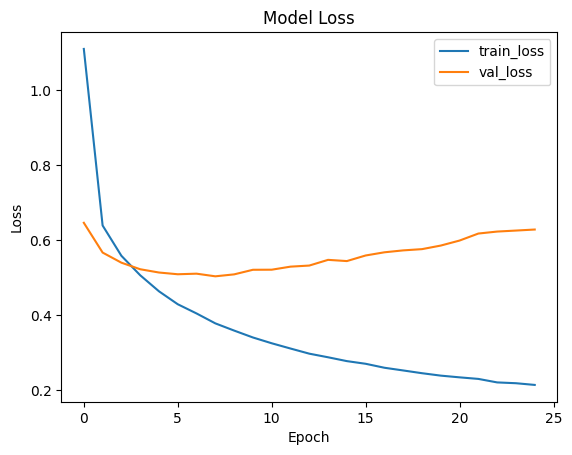

In [344]:
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [345]:
y_pred_proba = model.predict([X_test_emb, X_test_ts])
y_pred = np.argmax(y_pred_proba, axis=1)

1059/1059 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step


In [346]:
report = classification_report(y_test, y_pred, target_names=[f'Class {i}' for i in range(121)])
print("Classification Report for Validation Data\n")
print(report)

Classification Report for Validation Data

              precision    recall  f1-score   support

     Class 0       0.92      0.92      0.92      2811
     Class 1       0.92      0.94      0.93      1095
     Class 2       0.93      0.92      0.92      1112
     Class 3       0.88      0.88      0.88       665
     Class 4       0.91      0.93      0.92       685
     Class 5       0.74      0.90      0.81       936
     Class 6       0.82      0.93      0.87       686
     Class 7       0.89      0.90      0.90       592
     Class 8       0.94      0.89      0.91       701
     Class 9       0.98      0.98      0.98       502
    Class 10       0.91      0.91      0.91       499
    Class 11       0.80      0.88      0.84       529
    Class 12       0.96      0.92      0.94       427
    Class 13       0.93      0.92      0.92       377
    Class 14       0.83      0.86      0.85       443
    Class 15       0.88      0.92      0.90       585
    Class 16       0.93      0.96     

In [347]:
y_test_binarized = label_binarize(y_test, classes=np.arange(121))
auc_score = roc_auc_score(y_test_binarized, y_pred_proba, average="macro", multi_class="ovr")
print(f'Total AUC Score Validation Data: {auc_score:.4f}')

Total AUC Score Validation Data: 0.9982


In [348]:
y_train_pred_proba = model.predict([X_train_emb, X_train_ts])
y_train_pred = np.argmax(y_train_pred_proba, axis=1)
train_report = classification_report(y_train, y_train_pred, target_names=[f'Class {i}' for i in range(121)])
print("Classification Report for Training Set\n")
print(train_report)

4233/4233 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step
Classification Report for Training Set

              precision    recall  f1-score   support

     Class 0       0.98      0.98      0.98     11272
     Class 1       0.98      0.99      0.98      4270
     Class 2       0.99      0.98      0.98      4584
     Class 3       0.97      0.96      0.97      2703
     Class 4       0.96      0.99      0.97      2502
     Class 5       0.90      0.99      0.94      3648
     Class 6       0.93      0.99      0.96      2739
     Class 7       0.96      0.97      0.97      2254
     Class 8       0.99      0.97      0.98      2582
     Class 9       0.99      0.99      0.99      1960
    Class 10       0.98      0.98      0.98      2063
    Class 11       0.93      0.97      0.95      2163
    Class 12       0.99      0.97      0.98      1673
    Class 13       0.99      0.98      0.99      1593
    Class 14       0.97      0.98      0.97      1771
    Class 15       0.97      0.98      0.98      24

In [349]:
y_train_binarized = label_binarize(y_train, classes=np.arange(121))
train_auc_score = roc_auc_score(y_train_binarized, y_train_pred_proba, average="macro", multi_class="ovr")
print(f'Total AUC Score Training Data: {train_auc_score:.4f}')

Total AUC Score Training Data: 0.9999


In [350]:
model.save('LSTM_content.h5')

# 2° Model

In [54]:
# Define the embedding input layer
embedding_input = Input(shape=(384,))

# Define the timestamp input layer
timestamp_input = Input(shape=(1,))

# Dense layer applied to the embedding input
x = Dense(512, activation='relu')(embedding_input)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)
x = Dense(256, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)

# Bidirectional LSTM layer applied to the timestamp input
# Add an extra dimension to fit the LSTM input shape requirement
timestamp_input_reshaped = Reshape((1, 1))(timestamp_input)
y = Bidirectional(LSTM(100, return_sequences=False))(timestamp_input_reshaped)
y = Dropout(0.3)(y)

# Concatenate the outputs of the dense and LSTM layers
combined = concatenate([x, y])

# Additional dense layer with ReLU activation
z = Dense(200, activation='relu')(combined)
z = BatchNormalization()(z)
z = Dropout(0.3)(z)

# Output layer with softmax activation for multi-class classification
output = Dense(121, activation='softmax')(z)

# Define the model with input and output layers
model = Model(inputs=[embedding_input, timestamp_input], outputs=output)

# Compile the model with Adam optimizer, sparse categorical crossentropy loss,
# and metrics including accuracy and sparse categorical accuracy
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', 
              metrics=['accuracy', 'sparse_categorical_accuracy'])

In [55]:
early_stopping_callback = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
model_checkpoint_callback = ModelCheckpoint(filepath='model_2checkpoint.weights.h5', save_weights_only=True,
                                            monitor='val_accuracy', mode='max', save_best_only=True)
reduce = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)

# Train the model
history = model.fit(
    [X_train_emb, X_train_ts],  # input for embeddings and time series
    y_train,  # multilabel binary targets
    epochs=100,  # number of epochs
    batch_size=32,  # batch size
    validation_data=([X_test_emb, X_test_ts], y_test),  # validation data
    callbacks=[early_stopping_callback, model_checkpoint_callback, reduce]  # callbacks
)

Epoch 1/100
4233/4233 ━━━━━━━━━━━━━━━━━━━━ 48s 10ms/step - accuracy: 0.5943 - loss: 1.6586 - sparse_categorical_accuracy: 0.5943 - val_accuracy: 0.8150 - val_loss: 0.6173 - val_sparse_categorical_accuracy: 0.8150 - learning_rate: 0.0010
Epoch 2/100
4233/4233 ━━━━━━━━━━━━━━━━━━━━ 47s 11ms/step - accuracy: 0.7672 - loss: 0.8122 - sparse_categorical_accuracy: 0.7672 - val_accuracy: 0.8339 - val_loss: 0.5485 - val_sparse_categorical_accuracy: 0.8339 - learning_rate: 0.0010
Epoch 3/100
4233/4233 ━━━━━━━━━━━━━━━━━━━━ 37s 9ms/step - accuracy: 0.7925 - loss: 0.7130 - sparse_categorical_accuracy: 0.7925 - val_accuracy: 0.8393 - val_loss: 0.5297 - val_sparse_categorical_accuracy: 0.8393 - learning_rate: 0.0010
Epoch 4/100
4233/4233 ━━━━━━━━━━━━━━━━━━━━ 41s 10ms/step - accuracy: 0.8073 - loss: 0.6497 - sparse_categorical_accuracy: 0.8073 - val_accuracy: 0.8456 - val_loss: 0.5167 - val_sparse_categorical_accuracy: 0.8456 - learning_rate: 0.0010
Epoch 5/100
4233/4233 ━━━━━━━━━━━━━━━━━━━━ 50s 12ms/s

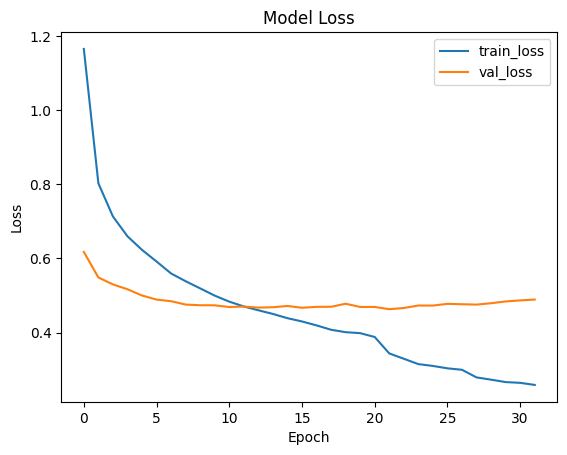

In [56]:
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

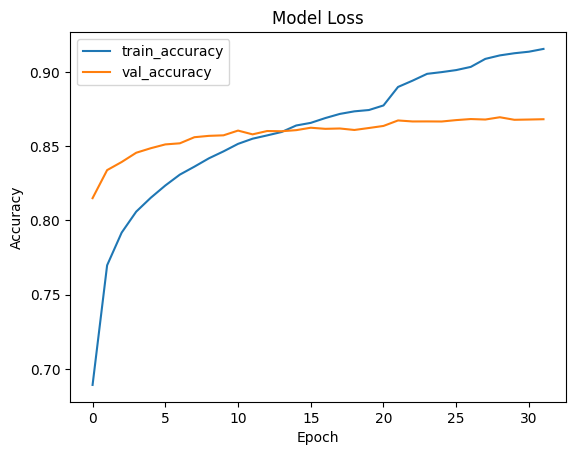

In [58]:
plt.plot(history.history['accuracy'], label='train_accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [59]:
y_pred_proba = model.predict([X_test_emb, X_test_ts])
y_pred = np.argmax(y_pred_proba, axis=1)
report = classification_report(y_test, y_pred, target_names=[f'Class {i}' for i in range(121)])
print("Classification Report for Validation Data\n")
print(report)

1059/1059 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step
Classification Report for Validation Data

              precision    recall  f1-score   support

     Class 0       0.91      0.94      0.93      2811
     Class 1       0.95      0.94      0.95      1095
     Class 2       0.95      0.93      0.94      1112
     Class 3       0.86      0.91      0.89       665
     Class 4       0.93      0.94      0.93       685
     Class 5       0.84      0.87      0.86       936
     Class 6       0.90      0.89      0.89       686
     Class 7       0.92      0.93      0.92       592
     Class 8       0.91      0.92      0.92       701
     Class 9       0.98      0.98      0.98       502
    Class 10       0.92      0.95      0.93       499
    Class 11       0.84      0.87      0.86       529
    Class 12       0.96      0.94      0.95       427
    Class 13       0.91      0.96      0.94       377
    Class 14       0.86      0.88      0.87       443
    Class 15       0.89      0.92      0.91      

In [60]:
y_test_binarized = label_binarize(y_test, classes=np.arange(121))
auc_score = roc_auc_score(y_test_binarized, y_pred_proba, average="macro", multi_class="ovr")
print(f'Total AUC Score Validation Data: {auc_score:.4f}')

Total AUC Score Validation Data: 0.9985


In [62]:
model.save('LSTM2_content.keras')

## Conclusion: 
The first model differs from the first by a few fewer points on the metrics but is a simpler model than the second.

Although we did not obtain a very high accuracy, however, the results are optimal and this proves that even in the face of numerous data and numerous classes, the neural network fits well by handling both the input as a time series (when the post was written) and the post itself (embedding of BERTopic).

By having more datasets and more LSTM models at one's disposal, it is possible to compare the trends over time of the various forums and have a global view of the evolution of criminal language, not only at the level of a single forum but throughout the entire dark web.